# VR $p_T$ Rescaling

**Motivation:** To really motivate the need for this VR retraining, Rafael wanted me to look at how much we could gain from the extended pflow retraining if we scaled the VR track jet $p_T$ to a pflow compatible value since $p_T^{frac}$ was the variable with the largest discrepancy when I was just looking at distribuions.  

In [4]:
import numpy as np
import h5py
import sys
import pandas as pd
import xarray as xr

sys.path.append("../..")
from usefulFcts import *
from trainNet import *
from plottingFcts import *

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## $t\bar{t}$ evaluation

In [5]:
jetCollection = 'VR'
vStr = "sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits"
df_tag = '2mtest_15trks_sd0_rev'

nFeatures=13
figDir = '../../figures/'

nTest = int(1.5e6)
nTrks_te = 15
nTrks_tr = 15

In [6]:
leffs, ceffs, beffs, = [],[],[]
discs, labels = [],[]
ys, pts, etas = [],[],[]

physicsSample = 'ttbar'
dataDir = '../../data/mc16d_{}_{}'.format(jetCollection,physicsSample)

# Also open the df so that you'll have access to the jet pt and eta
jet_df = pd.read_hdf('{}/jet_{}.h5'.format(dataDir,df_tag), key='jet_df')
trk_xr = xr.open_dataarray('{}/trk_{}.nc'.format(dataDir,df_tag))

print('Evaluating on {}\n'.format(physicsSample))

for trJetCol, trainPhysicsSample, Ntrain, nHidden in \
    zip(['VR','PFlow'], ['ttbar','hybrid_5TeV'], [int(2e6),int(5e6)], [200,400]):

    # Load in the sample for evaluation
    subDir = 'mc16d_{}_{}'.format(jetCollection,physicsSample)
    dataDir = '../../data/'+subDir
    scale_tag = "_{}_scale".format(trainPhysicsSample) if physicsSample != trainPhysicsSample else ""
    if trJetCol != jetCollection:
        scale_tag = '_' + trJetCol + scale_tag

    dataTagTest = "2mtest_{}trks_{}_sd0_rev{}".format(nTrks_te,vStr, scale_tag)

    f_name = "{}/data_{}.hdf5".format(dataDir,dataTagTest)
    f = h5py.File(f_name,"r")

    X = f['X_test'][:]
    y = f['y_test'][:]
    ix = f['ix_test'][:]

    f.close()

    # Load in the model
    modelDir = "../../models/mc16d_{}_{}".format(trJetCol,trainPhysicsSample)
    dataTagTrain = "{}train_{}trks_{}_sd0_rev".format(nJetsTag(Ntrain),nTrks_tr,vStr)
    m = myLSTM(modelDir=modelDir, nFeatures=nFeatures, nHidden=nHidden, dataTag=dataTagTrain, loadModel=True)

    # Get the efficiencies
    tag = '_eval_{}_pt_10GeV'.format(physicsSample) if physicsSample != trainPhysicsSample else ''
    (leff, ceff, beff), d = getEffs(m, X, y, ix, returnDisc=True,
                                    figDir=figDir,subDir=subDir,modelDir=modelDir,tag=tag)

    leffs.append(leff)
    ceffs.append(ceff)
    beffs.append(beff)

    discs.append(d)
    labels.append('train {}, eval {}'.format(trainPhysicsSample,physicsSample))

    ys.append(y)
    pts.append(jet_df.pt.values)
    etas.append(jet_df.eta.values)


Evaluating on ttbar

Initialize method from myModel()
Loading previously trained LSTM
Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained LSTM
Load in the previously saved efficiency file


**Rescale the $p_T^{frac}$ variable**

<img src="../../figures/mc16d_VR_ttbar/PFlow_cf/jet_pt_2d_scatter.pdf" width="350">

The VR track jet carries about half of the $p_T$ of the calo jet, so recalculate $p_T^{frac}$ as:

$p_T^{frac} = \frac{p_T^{trk}}{p_T^{jet}} \rightarrow \frac{1}{2} \frac{p_T^{trk}}{p_T^{jet}}$

I will then need to take the $\log$, and apply the pflow scaling.

**Expectations** I think this is a *horrible* idea because this method is just correcting the mean of the distribution, but not the varaiance, and VR track jets have a larger spread than the calo jets.

Also, looking at this plot (although made with the 5 GeV $p_T$ cut and without the VR OR) 

<img src="../../figures/mc16d_VR_ttbar/PFlow_cf/ptfrac.pdf" width="350">

shows that it seems like it would be unlikely that this modification will solve the problem, although it will likely help.

In [7]:
mask = ~ np.all(trk_xr.values == 0, axis=-1)

In [8]:
ptfrac = trk_xr.loc[:,:,'ptfrac'].values

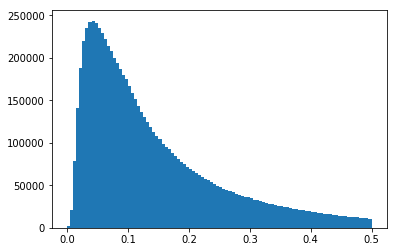

In [9]:
plt.hist(ptfrac[mask],100,(0,0.5))
plt.show()

Hmmmm... it's interesting to me that these different VR cuts could allow me to come to such a different conclusion this VR distribution doesn't have that wierd shelf... perhaps it could be worthwhile to remake this plot overlaying with the pflow result?

In [10]:
# Load in the mean and sd from the pflow scaling file
dataTagTrain = "5mtrain_15trks_{}".format(vStr)
subDir = 'mc16d_PFlow_hybrid_5TeV'
s_name = "../../data/{}/scale_{}.json".format(subDir,dataTagTrain)
with open(s_name, 'r') as sfile:
    d = json.load(sfile)
mu, sigma = d['ptfrac']['mean'], d['ptfrac']['sd']

d

{'ptfrac': {'mean': -3.7198679447174072, 'sd': 1.6432801485061646},
 'dr': {'mean': -2.7787461280822754, 'sd': 1.1020185947418213},
 'nPixHits': {'mean': 4.066926956176758, 'sd': 0.8257577419281006},
 'nSCTHits': {'mean': 8.087814331054688, 'sd': 1.3968151807785034}}

In [11]:
ptfrac_scaled = (np.log(0.5 * ptfrac[mask]) - mu) / sigma

In [12]:
Xnew = X.copy()
Xnew[:,:,-4][mask] = ptfrac_scaled

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


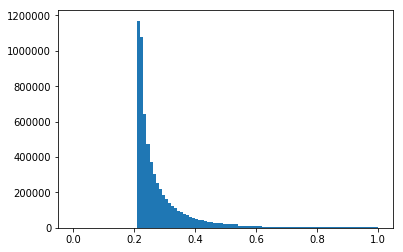

In [13]:
plt.hist(ptfrac[mask]/ptfrac_scaled,100,(0,1))
plt.show()

**Evaluate on the pflow trained model again**

In [14]:
tag

'_eval_ttbar_pt_10GeV'

In [15]:
tag = '_eval_{}_pt_10GeV_ptfrac_rescaled'.format(physicsSample) 
(leff, ceff, beff), d = getEffs(m, Xnew, y, ix, returnDisc=True,
                                figDir=figDir,subDir=subDir,
                                modelDir=modelDir,tag=tag)

leffs.append(leff)
ceffs.append(ceff)
beffs.append(beff)

discs.append(d)

Load in the previously saved efficiency file


/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:117: RuntimeWarning: invalid value encountered in multiply
  d = ((2*h0 + h1)*m0 - h0*m1) / (h0 + h1)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: invalid value encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk


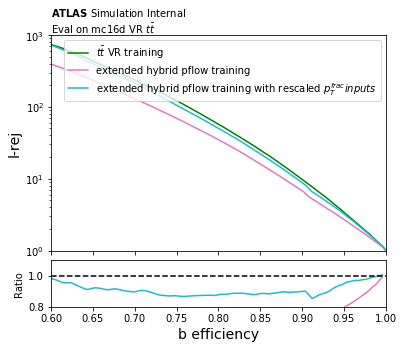

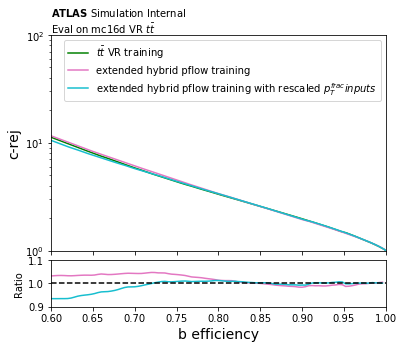

In [18]:
train_labels = [r"$t\bar{t}$ VR training","extended hybrid pflow training","extended hybrid pflow training with rescaled $p_T^{frac} inputs$"]
ntests = [np.sum(ys[0]==label) for label in range(3) ]

subDir = 'mc16d_VR_ttbar'
plotTag = 'rej_rescaledPtFrac'

text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+=r"Eval on mc16d VR $t\bar{t}$"

colors = ['green','C6','C9']

plotROCRatio(beffs, leffs, 
             train_labels, rrange=(.8,1.1),ymax=1000,
             text=text,ylabel='l-rej',binomialErrors=False,nTest=ntests, 
             colors=colors, figDir=figDir,subDir=subDir,tag='l'+plotTag)

plotROCRatio(beffs, ceffs, 
             train_labels, rrange=(.9,1.1),ymax=100,
             text=text,ylabel='c-rej',binomialErrors=False,nTest=ntests, 
             colors=colors, figDir=figDir,subDir=subDir,tag='c'+plotTag)

**Lesson:** We're getting a *good portion* of the way there, just by rescaling the efficiencies in this way!

I think the next step is to see how this compares with the Z' evaluation.

## Z' evaluation

In [19]:
leffs, ceffs, beffs, = [],[],[]
discs, labels = [],[]
ys, pts, etas = [],[],[]

physicsSample = 'Zprime_1.5TeV_2lead'
df_tag = '1000ktest_25trks_sd0_rev'
dataDir = '../../data/mc16d_{}_{}'.format(jetCollection,physicsSample)

# Also open the df so that you'll have access to the jet pt and eta
jet_df = pd.read_hdf('{}/jet_{}.h5'.format(dataDir,df_tag), key='jet_df')
trk_xr = xr.open_dataarray('{}/trk_{}.nc'.format(dataDir,df_tag))
nTrks_te = 25

print('Evaluating on {}\n'.format(physicsSample))

for trJetCol, trainPhysicsSample, Ntrain, nHidden, nTrks_tr in \
    zip(['VR','PFlow'], ['Zprime_1.5TeV','hybrid_5TeV'], [int(3e6),int(5e6)], [200,400], [25,15]):

    # Load in the sample for evaluation
    subDir = 'mc16d_{}_{}'.format(jetCollection,physicsSample)
    dataDir = '../../data/'+subDir
    scale_tag = "_{}_scale".format(trainPhysicsSample) if physicsSample != trainPhysicsSample else ""
    if trJetCol != jetCollection:
        scale_tag = '_' + trJetCol + scale_tag

    dataTagTest = "1000ktest_{}trks_{}_sd0_rev{}".format(nTrks_te,vStr, scale_tag)

    f_name = "{}/data_{}.hdf5".format(dataDir,dataTagTest)
    f = h5py.File(f_name,"r")

    X = f['X_test'][:]
    y = f['y_test'][:]
    ix = f['ix_test'][:]

    f.close()

    nTest = X.shape[0]
    nTest = X.shape[0]
    if nTrks_te > nTrks_tr:
        # Restrict the # of tracks you're evaluating with
        X = X[:,:nTrks_tr,:]
    if nTrks_te < nTrks_tr:
        # Append 0s
        zeros = np.zeros((nTest,nTrks_tr-nTrks_te,nFeatures))
        X = np.concatenate((X,zeros),axis=1)
    
    # Load in the model
    modelDir = "../../models/mc16d_{}_{}".format(trJetCol,trainPhysicsSample)
    dataTagTrain = "{}train_{}trks_{}_sd0_rev".format(nJetsTag(Ntrain),nTrks_tr,vStr)
    m = myLSTM(modelDir=modelDir, nFeatures=nFeatures, nHidden=nHidden, dataTag=dataTagTrain, loadModel=True)

    # Get the efficiencies
    tag = '_eval_{}_pt_10GeV'.format(physicsSample) if physicsSample != trainPhysicsSample else ''
    (leff, ceff, beff), d = getEffs(m, X, y, ix, returnDisc=True,
                                    figDir=figDir,subDir=subDir,modelDir=modelDir,tag=tag)

    leffs.append(leff)
    ceffs.append(ceff)
    beffs.append(beff)

    discs.append(d)
    labels.append('train {}, eval {}'.format(trainPhysicsSample,physicsSample))

    ys.append(y)
    pts.append(jet_df.pt.values)
    etas.append(jet_df.eta.values)



Evaluating on Zprime_1.5TeV_2lead

Initialize method from myModel()
Loading previously trained LSTM
Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained LSTM
Load in the previously saved efficiency file


In [20]:
mask = ~ np.all(trk_xr.values == 0, axis=-1)
ptfrac = trk_xr.loc[:,:14,'ptfrac'].values

ptfrac_scaled = (np.log(0.5 * ptfrac[mask[:,:15]]) - mu) / sigma
Xnew = X.copy()
Xnew[:,:,-4][mask[:,:15]] = ptfrac_scaled

In [21]:
tag = '_eval_{}_pt_10GeV_ptfrac_rescaled'.format(physicsSample) 
(leff, ceff, beff), d = getEffs(m, Xnew, y, ix, returnDisc=True,
                                figDir=figDir,subDir=subDir,
                                modelDir=modelDir,tag=tag)

leffs.append(leff)
ceffs.append(ceff)
beffs.append(beff)

discs.append(d)

Load in the previously saved efficiency file


/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: invalid value encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:117: RuntimeWarning: invalid value encountered in multiply
  d = ((2*h0 + h1)*m0 - h0*m1) / (h0 + h1)


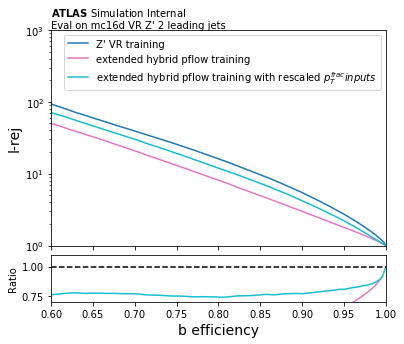

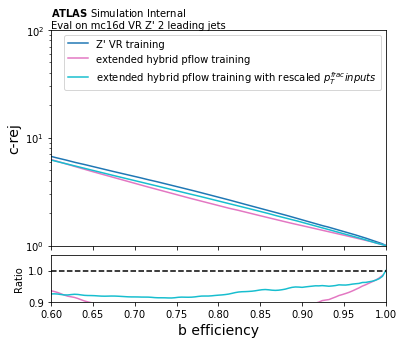

In [24]:
train_labels = [r"Z' VR training","extended hybrid pflow training","extended hybrid pflow training with rescaled $p_T^{frac} inputs$"]
ntests = [np.sum(ys[0]==label) for label in range(3) ]

subDir = 'mc16d_VR_Zprime_1.5TeV_2lead'

text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+=r"Eval on mc16d VR Z' 2 leading jets"

colors = ['C0','C6','C9']

plotROCRatio(beffs, leffs, 
             train_labels, rrange=(.7,1.1),ymax=1000,
             text=text,ylabel='l-rej',binomialErrors=False,nTest=ntests, 
             colors=colors, figDir=figDir,subDir=subDir,tag='l'+plotTag)

plotROCRatio(beffs, ceffs, 
             train_labels, rrange=(.9,1.05),ymax=100,
             text=text,ylabel='c-rej',binomialErrors=False,nTest=ntests, 
             colors=colors, figDir=figDir,subDir=subDir,tag='c'+plotTag)